In [1]:
import os, sys, mne, socket, time
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from nilearn import plotting
from itertools import product

# Decoding tools
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from mne.decoding import (
    CSP,
    GeneralizingEstimator,
    LinearModel,
    Scaler,
    SlidingEstimator,
    GeneralizingEstimator,
    Vectorizer,
    cross_val_multiscore,
    get_coef,
)

from initialization import load_paths
from preprocFuncs import getRawData, getTrials
# from plotters import plotPower, plotRSA, plotDiffRSA
from decodeHelpers import *

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
subjID = 1
master_df =  pd.read_csv('/d/DATD/datd/MD_TMS_EEG/analysis/meta_analysis/master_df_calib.csv')
day = master_df[(master_df['subjID'] == subjID) & (master_df['istms']==0)]['day'].unique()[0]
p = load_paths(subjID, day)
# Load behavioral data
behav_df = master_df[(master_df['subjID'] == subjID) & (master_df['day'] == day)]
# Load raw data
raw_data = getRawData(p)

# Define events
events, tah = mne.events_from_annotations(raw_data)
events_dict = {
    'BlockStart': 1001,
    'Fixation': 1,
    'Delay1': 2,
    'Delay2': 3,
    'Response': 4,
    'Feedback': 6,
    'ITI': 7,
    'BlockEnd': 8,
}
trl_events = {
    'pro_inPF': 11,
    'pro_outPF': 12,
    'anti_inPF': 13,
    'anti_outPF': 14
}

# Define electrodes of interest
left_occ_elecs = ['O1', 'PO3', 'PO7', 'P1', 'P3', 'P7']
right_occ_elecs = ['O2', 'PO4', 'PO8', 'P2', 'P4', 'P8']
left_par_elecs = ['P7', 'P5', 'P3', 'CP5', 'CP3', 'CP1', 'C5', 'C3', 'C1']
right_par_elecs = ['P8', 'P6', 'P4', 'CP6', 'CP4', 'CP2', 'C6', 'C4', 'C2']

left_elecs = ['O1', 'PO3', 'PO7', 'P1', 'P3', 'P7', 'P5', 'CP5', 'CP3', 'CP1', 'C5', 'C3', 'C1']
right_elecs = ['O2', 'PO4', 'PO8', 'P2', 'P4', 'P8', 'P6', 'CP6', 'CP4', 'CP2', 'C6', 'C4', 'C2']

left_occ_elecs = [elec for elec in left_occ_elecs if elec in raw_data.ch_names]
right_occ_elecs = [elec for elec in right_occ_elecs if elec in raw_data.ch_names]
left_par_elecs = [elec for elec in left_par_elecs if elec in raw_data.ch_names]
right_par_elecs = [elec for elec in right_par_elecs if elec in raw_data.ch_names]
left_elecs = [elec for elec in left_elecs if elec in raw_data.ch_names]
right_elecs = [elec for elec in right_elecs if elec in raw_data.ch_names]

Running pre-processing ...
Extracting parameters from /d/DATD/datd/MD_TMS_EEG/EEGfiles/sub01/day02/sub01_day02.vhdr...
Setting channel info structure...
Reading 0 ... 4036319  =      0.000 ...  4036.319 secs...
Writing /d/DATD/datd/MD_TMS_EEG/EEGpy/sub01/day02/sub01_day02_raw.fif
Closing /d/DATD/datd/MD_TMS_EEG/EEGpy/sub01/day02/sub01_day02_raw.fif
[done]
Used Annotations descriptions: ['Response/R  1', 'Stimulus/S  1', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S  6', 'Stimulus/S  7', 'Stimulus/S  8', 'Stimulus/S 11', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14']


In [14]:
raw_temp = raw_data.copy()
sfreq = raw_temp.info['sfreq']
n_times = raw_temp.times.shape[0]
ecg_data = np.sin(2 * np.pi * 1 * np.arange(n_times) / sfreq)
ecg_info = mne.create_info(['ECG'], sfreq, ch_types='ecg')
ecg_raw = mne.io.RawArray([ecg_data], ecg_info)
raw_temp.add_channels([ecg_raw])


raw_filtered = raw_temp.copy().filter(l_freq=1, h_freq=40, fir_design='firwin', verbose=False)


Creating RawArray with float64 data, n_channels=1, n_times=4036320
    Range : 0 ... 4036319 =      0.000 ...  4036.319 secs
Ready.


In [15]:
ica = mne.preprocessing.ICA(n_components=20, random_state=42, max_iter=800)
ica.fit(raw_filtered)
eogblink_inds, _ = ica.find_bads_eog(raw_filtered, ch_name='Fp1', threshold=3, verbose=False)
eogsaccade_inds, _ = ica.find_bads_eog(raw_filtered, ch_name='F7', threshold=3, verbose=False)

Fitting ICA to data using 63 channels (please be patient, this may take a while)
Selecting by number: 20 components
Fitting ICA took 100.5s.


Method,fastica
Fit parameters,algorithm=parallelfun=logcoshfun_args=Nonemax_iter=800
Fit,37 iterations on raw data (4036320 samples)
ICA components,20
Available PCA components,63
Channel types,eeg
ICA components marked for exclusion,—


In [16]:
eogblink_inds, _ = ica.find_bads_eog(raw_filtered, ch_name='Fp1', threshold=3, verbose=False)
eogsaccade_inds, _ = ica.find_bads_eog(raw_filtered, ch_name='F7', threshold=3, verbose=False)
print(eogblink_inds, eogsaccade_inds)

[0] []


In [9]:
eog_inds2, scores = ica.find_bads_eog(raw_filtered, ch_name='Fp2', threshold=3)
print(eog_inds, eog_inds2)

Using EOG channel: Fp2
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 10000 samples (10.000 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.4s


... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 10000 samples (10.000 s)

[0] [0]


In [17]:
ecg_inds, scores = ica.find_bads_ecg(raw_filtered)

Using threshold: 0.16 for CTPS ECG detection
Using channel ECG to identify heart beats.
Setting up band-pass filter from 8 - 16 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 8.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 7.75 Hz)
- Upper passband edge: 16.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 16.25 Hz)
- Filter length: 10000 samples (10.000 s)

Number of ECG events detected : 8065 (average pulse 119 / min.)
Not setting metadata
8065 matching events found
No baseline correction applied
Using data from preloaded Raw for 8065 events and 1001 original time points ...
1 bad epochs dropped


In [18]:
ecg_inds

[]

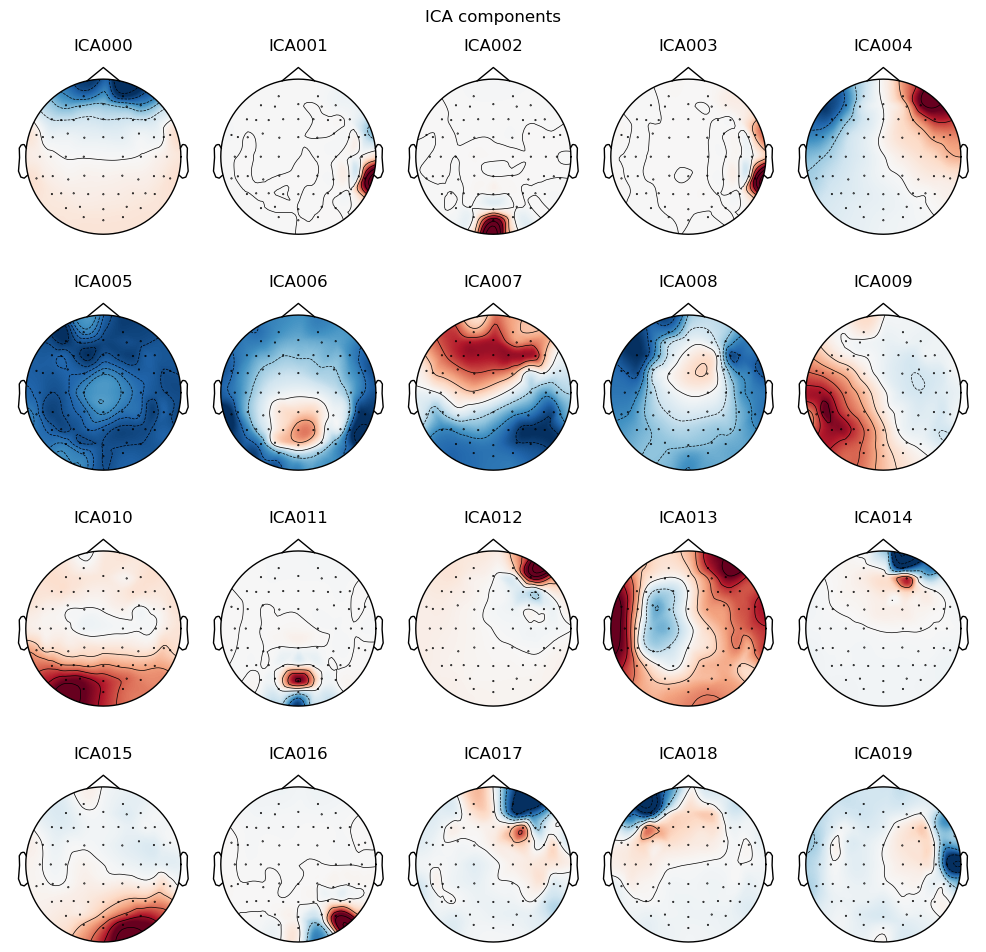

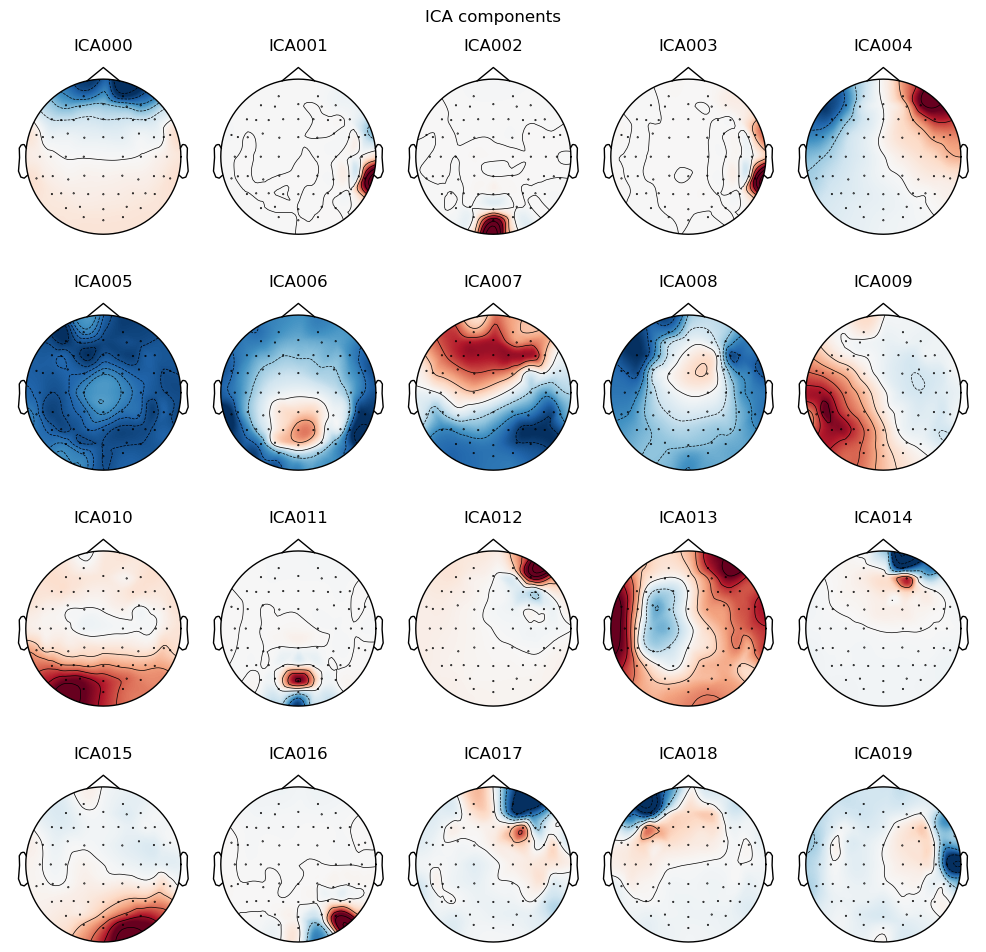

In [19]:
ica.plot_components()

In [3]:
ica_raw = mne.preprocessing.ICA(n_components=40, random_state=42, max_iter='auto', method='fastica', verbose=True)
ica_raw.fit(raw_data)
if subjID == 1:
    if day == 1:
        ica_raw.exclude = [11, 18] # check again
    elif day == 2:
        ica_raw.exclude = [0, 2]
elif subjID == 12:
    if day == 2:
        ica_raw.exclude = [0, 11]
raw_data = ica_raw.apply(raw_data)

Fitting ICA to data using 55 channels (please be patient, this may take a while)
Selecting by number: 40 components
Fitting ICA took 273.0s.


In [ ]:
# ica_raw.plot_components()
ica_raw.plot_properties(raw_data, picks=[0, 2, 5, 11, 12, 18, 19, 31, 35])

In [7]:
if 'Cz' not in raw_data.ch_names:
    raw_data = raw_data.add_reference_channels(ref_channels=['Cz'])
raw_data.set_eeg_reference(ref_channels='average')

raw_data.save(p['fif_path'], overwrite=True)

/var/folders/cf/d9j3_ppd5wb4bn9y_fgj3nb800010l/T/ipykernel_71416/1877446803.py:2: RuntimeWarning: The locations of multiple reference channels are ignored.
  raw_data = raw_data.add_reference_channels(ref_channels=['Cz'])


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Overwriting existing file.
Writing /d/DATD/datd/MD_TMS_EEG/EEGpy/sub12/day02/sub12_day02_raw.fif
Closing /d/DATD/datd/MD_TMS_EEG/EEGpy/sub12/day02/sub12_day02_raw.fif
[done]


In [3]:
epochData = mne.Epochs(raw_data, events, event_id=trl_events, tmin=-1, tmax=4.5, baseline=None, preload=True)
epochDataBasecorr = mne.Epochs(raw_data, events, event_id=trl_events, tmin=-1, tmax=4.5, baseline=(-1, 0), preload=True)
proInPF = epochData.events[:, 2] == trl_events['pro_inPF']
proOutPF = epochData.events[:, 2] == trl_events['pro_outPF']
antiInPF = epochData.events[:, 2] == trl_events['anti_inPF']
antiOutPF = epochData.events[:, 2] == trl_events['anti_outPF']

Not setting metadata
400 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 400 events and 5501 original time points ...
0 bad epochs dropped
Not setting metadata
400 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 400 events and 5501 original time points ...
0 bad epochs dropped


/var/folders/cf/d9j3_ppd5wb4bn9y_fgj3nb800010l/T/ipykernel_78211/2023187182.py:1: RuntimeWarning: filter_length (33001) is longer than the signal (5501), distortion is likely. Reduce filter length or filter a longer signal.
  erpData = epochData.copy().filter(l_freq=0.1, h_freq=6, n_jobs=-1, verbose=False)
/var/folders/cf/d9j3_ppd5wb4bn9y_fgj3nb800010l/T/ipykernel_78211/2023187182.py:27: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


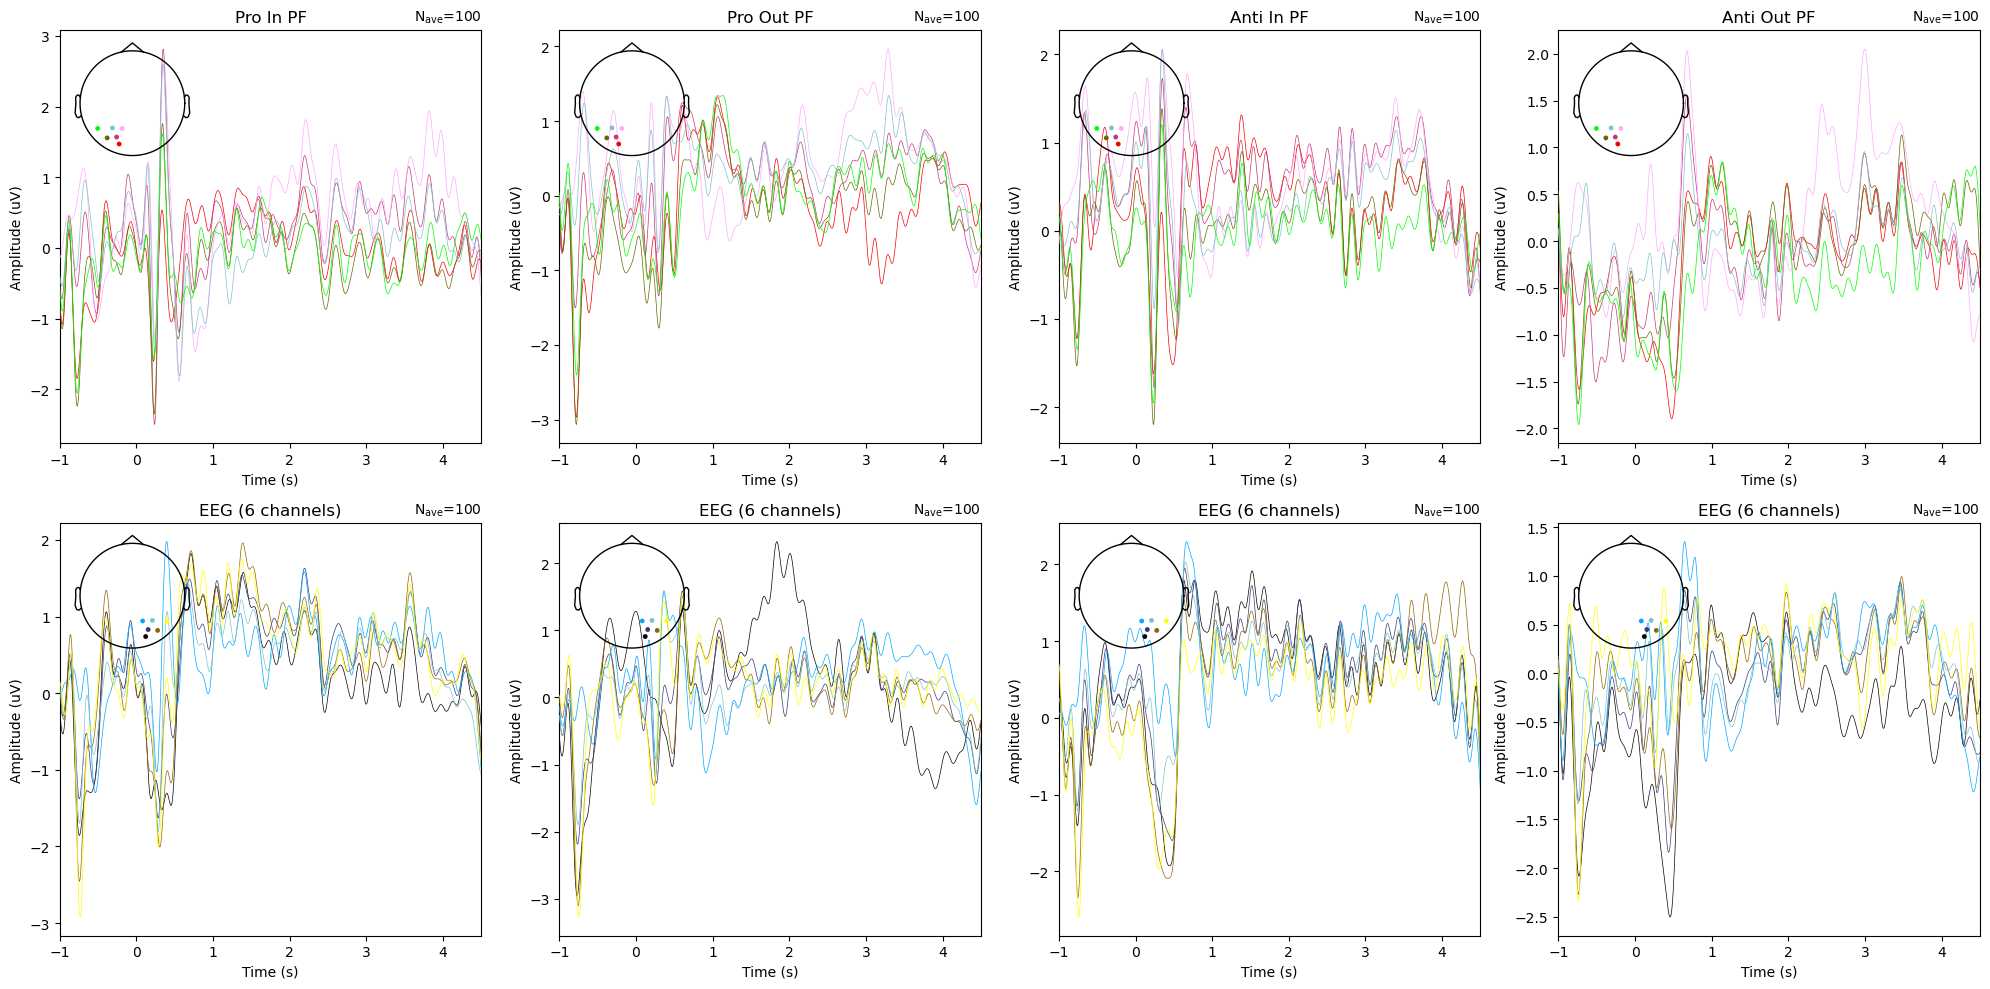

In [4]:
erpData = epochData.copy().filter(l_freq=0.1, h_freq=6, n_jobs=-1, verbose=False)

evoked_proInPF = erpData[proInPF].average()
evoked_proOutPF = erpData[proOutPF].average()
evoked_antiInPF = erpData[antiInPF].average()
evoked_antiOutPF = erpData[antiOutPF].average()
f, axs = plt.subplots(2, 4, figsize=(20, 10))
axs = axs.flatten()
evoked_proInPF.plot(picks=left_occ_elecs, show=False, axes=axs[0])
evoked_proOutPF.plot(picks=left_occ_elecs, show=False, axes=axs[1])
evoked_antiInPF.plot(picks=left_occ_elecs, show=False, axes=axs[2])
evoked_antiOutPF.plot(picks=left_occ_elecs, show=False, axes=axs[3])

evoked_proInPF.plot(picks=right_occ_elecs, show=False, axes=axs[4])
evoked_proOutPF.plot(picks=right_occ_elecs, show=False, axes=axs[5])
evoked_antiInPF.plot(picks=right_occ_elecs, show=False, axes=axs[6])
evoked_antiOutPF.plot(picks=right_occ_elecs, show=False, axes=axs[7])
for ax in axs:
    # ax.set_ylim
    ax.set_ylabel('Amplitude (uV)')
    ax.set_xlabel('Time (s)')
    # ax.text(
axs[0].set_title('Pro In PF')
axs[1].set_title('Pro Out PF')
axs[2].set_title('Anti In PF')
axs[3].set_title('Anti Out PF')
plt.tight_layout()
plt.show()

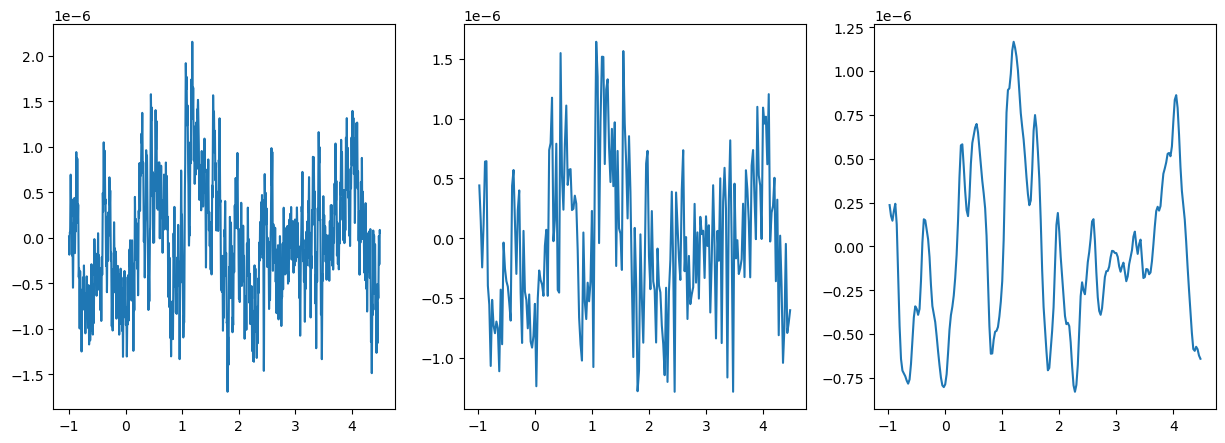

In [10]:
w_size = 1.5
down_wsize = 25
t_array = epochData.times
X = epochData.get_data(copy=True)
occ_elecs = left_occ_elecs + right_occ_elecs
occElecsIdx = [epochData.ch_names.index(elec) for elec in occ_elecs]
X = X[:, occElecsIdx, :]
y = epochData.events[:, 2].copy()

X_down, t_array_down = X[:, :, down_wsize:-down_wsize:down_wsize], t_array[down_wsize:-down_wsize:down_wsize]
X_smooth = gaussian_smooth_1d(X_down, sigma=w_size)

f, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].plot(t_array, X[y==11, :, :].mean(axis=(0,1)))
ax[1].plot(t_array_down, X_down[y==11, :, :].mean(axis=(0,1)))
ax[2].plot(t_array_down, X_smooth[y==11, :, :].mean(axis=(0,1)))
plt.show()


Setting up band-pass filter from 8 - 14 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 14.00 Hz
- Upper transition bandwidth: 3.50 Hz (-6 dB cutoff frequency: 15.75 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 2040 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 20288 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done 22400 out of 22400 | elapsed:    4.7s finished


IndexError: boolean index did not match indexed array along dimension 0; dimension is 400 but corresponding boolean dimension is 200

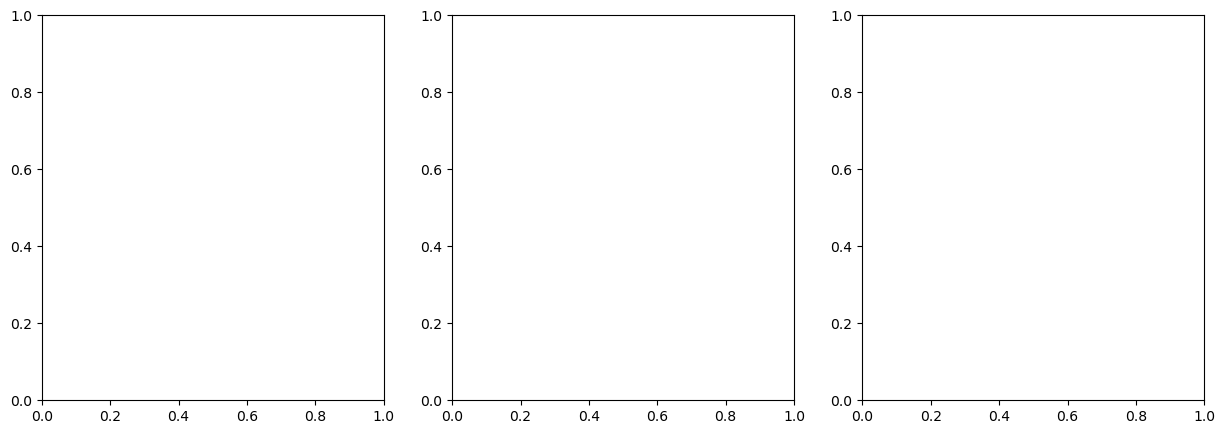

In [5]:
from scipy.signal import hilbert
w_size = 1.5
down_wsize = 50
freq_band = 'alpha'
pow_or_phase = 'pow'
if freq_band == 'alpha':
    lf, hf = 8, 14
elif freq_band == 'beta':
    lf, hf = 14, 20
elif freq_band == 'theta':
    lf, hf = 4, 8

t_array = epochData.times
# X = epochData.get_data(copy=True)
tempData = epochData.get_data(copy=True)

# tempData = (tempData - tempData.mean(axis=0)) / tempData.std(axis=0)
X = mne.filter.filter_data(tempData, sfreq=epochData.info['sfreq'], l_freq=lf, h_freq=hf, verbose=True, n_jobs=-1)
if pow_or_phase == 'pow':
    X = np.abs(hilbert(X)) ** 2
elif pow_or_phase == 'phase':
    X = np.angle(hilbert(X))

occ_elecs =  left_occ_elecs + right_occ_elecs 
# occ_elecs = left_par_elecs + right_par_elecs 
# occ_elecs = left_elecs + right_elecs
occElecsIdx = [epochDataBasecorr.ch_names.index(elec) for elec in occ_elecs]
X = X[:, occElecsIdx, :]
# X = np.log10(X)

y = epochData.events[:, 2].copy()
X_pro = X[(y == 11) | (y == 12), :, :]
y_pro = y[(y == 11) | (y == 12)]

y_hemi_stim = np.array([1 if y_pro == 11 else 0 for y_pro in y_pro]) # 1 for inPF, 0 for outPF
# y_hemi_stim = np.array([1 if y == 11 or y == 13 else 0 for y in y]) # 1 for inPF, 0 for outPF
y_hemi_resp = np.array([1 if y == 11 or y == 14 else 0 for y in y]) # 1 for pro inPF and anti outPF, 0 for pro outPF and anti inPF
y_trltype = np.array([0 if y == 11 or y == 12 else 1 for y in y]) # 0 for pro, 1 for anti


c1_trls = y_hemi_stim == 1
c2_trls = y_hemi_stim == 0

# X_down, t_array_down = moving_average_downsample(X, t_array, window_size=down_wsize)
X_down, t_array_down = X_pro[:, :, down_wsize:-down_wsize:down_wsize], t_array[down_wsize:-down_wsize:down_wsize]
# X_smooth = smooth_data(X, window_size=w_size)
X_smooth = gaussian_smooth_1d(X_down, sigma=w_size)

if pow_or_phase == 'pow':
    f, ax = plt.subplots(1, 3, figsize=(15, 5))
    ax[0].plot(t_array, X[c1_trls, :, :].mean(axis=(0,1)), label='cat1')
    ax[0].plot(t_array, X[c2_trls, :, :].mean(axis=(0,1)), label='cat2')
    ax[1].plot(t_array_down, X_down[c1_trls, :, :].mean(axis=(0,1)), label='cat1')
    ax[1].plot(t_array_down, X_down[c2_trls, :, :].mean(axis=(0,1)), label='cat2')
    ax[2].plot(t_array_down, X_smooth[c1_trls, :, :].mean(axis=(0,1)), label='cat1')
    ax[2].plot(t_array_down, X_smooth[c2_trls, :, :].mean(axis=(0,1)), label='cat2')
    plt.legend()
    plt.show()
else:
    from scipy.stats import circmean
    f, ax = plt.subplots(1, 3, figsize=(15, 5))
    ax[0].plot(t_array, circmean(X[c1_trls, :, :], axis=(0,1), high=np.pi, low=-np.pi), label='cat1')
    ax[0].plot(t_array, circmean(X[c2_trls, :, :], axis=(0,1), high=np.pi, low=-np.pi), label='cat2')
    ax[1].plot(t_array_down, circmean(X_down[c1_trls, :, :], axis=(0,1), high=np.pi, low=-np.pi), label='cat1')
    ax[1].plot(t_array_down, circmean(X_down[c2_trls, :, :], axis=(0,1), high=np.pi, low=-np.pi), label='cat2')
    ax[2].plot(t_array_down, circmean(X_smooth[c1_trls, :, :], axis=(0,1), high=np.pi, low=-np.pi), label='cat1')
    ax[2].plot(t_array_down, circmean(X_smooth[c2_trls, :, :], axis=(0,1), high=np.pi, low=-np.pi), label='cat2')
    plt.legend()
    plt.show()

In [6]:
from sklearn.svm import SVC

clf_temporal = make_pipeline(
    Vectorizer(),
    # StandardScaler(),
    # LogisticRegression(solver='liblinear'),
    # LinearModel(LogisticRegression(solver='liblinear')),
    SVC(kernel='rbf', C=1),
    # SVC(kernel='rbf', C=1, decision_function_shape='ovr', probability=True),
)

gen_decod = GeneralizingEstimator(clf_temporal, n_jobs=-1, scoring='roc_auc', verbose=True)
# gen_decod = GeneralizingEstimator(clf_temporal, n_jobs=4, scoring='roc_auc_ovr', verbose=True)

# scores = cross_val_multiscore(gen_decod, X_smooth, y_ori_cat, cv=5, n_jobs=-1)
# create dummies for y_ori
y_ori_dum = pd.Categorical(y).codes

scores = cross_val_multiscore(gen_decod, X_smooth, y_hemi_stim, cv=5, n_jobs=-1)

scores_mean = np.mean(scores, axis=0)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.










  0%|          | Fitting GeneralizingEstimator : 0/109 [00:00<?,       ?it/s]


 20%|██        | Fitting GeneralizingEstimator : 22/109 [00:00<00:00,  368.72it/s]



 34%|███▍      | Fitting GeneralizingEstimator : 37/109 [00:00<00:00,  536.90it/s]

 31%|███       | Fitting GeneralizingEstimator : 34/109 [00:00<00:00,  444.87it/s]
 33%|███▎      | Fitting GeneralizingEstimator : 36/109 [00:00<00:00,  449.27it/s]


 40%|████      | Fitting GeneralizingEstimator : 44/109 [00:00<00:00,  410.08it/s]
 61%|██████▏   | Fitting GeneralizingEstimator : 67/109 [00:00<00:00,  561.47it/s]

 69%|██████▉   | Fitting GeneralizingEstimator : 75/109 [00:00<00:00,  594.34it/s]



 78%|███████▊  | Fitting GeneralizingEstimator : 85/109 [00:00<00:00,  650.53it/s]


 72%|███████▏  | Fitting GeneralizingEstimator : 79/109 [00:00<00:00,  534.34it/s]
 88%|████████▊ | Fitting GeneralizingEstimator : 96/109 [00:00<00:00,  621.

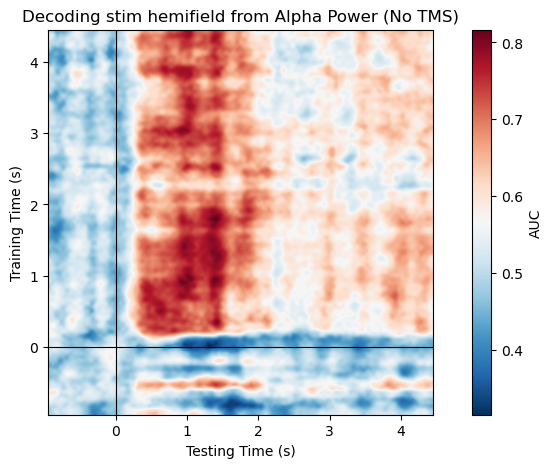

In [7]:
f, ax = plt.subplots(1, 1, figsize=(10, 5))
im = ax.imshow(scores_mean, 
               interpolation='lanczos', 
               origin='lower', 
               cmap='RdBu_r', 
               extent=[t_array_down[0], t_array_down[-1], t_array_down[0], t_array_down[-1]],
               )
ax.axhline(0, color='k', lw=0.8)
ax.axvline(0, color='k', lw=0.8)
ax.set_xlabel('Testing Time (s)')
ax.set_ylabel('Training Time (s)')
# ax.set_title('Decoding Hemifield from ERP')
ax.set_title('Decoding stim hemifield from Alpha Power (No TMS)')
cbar = plt.colorbar(im, ax=ax)
cbar.set_label('AUC')
plt.show()

In [8]:
np.save('scores_mean_NoTMS.npy', scores_mean)

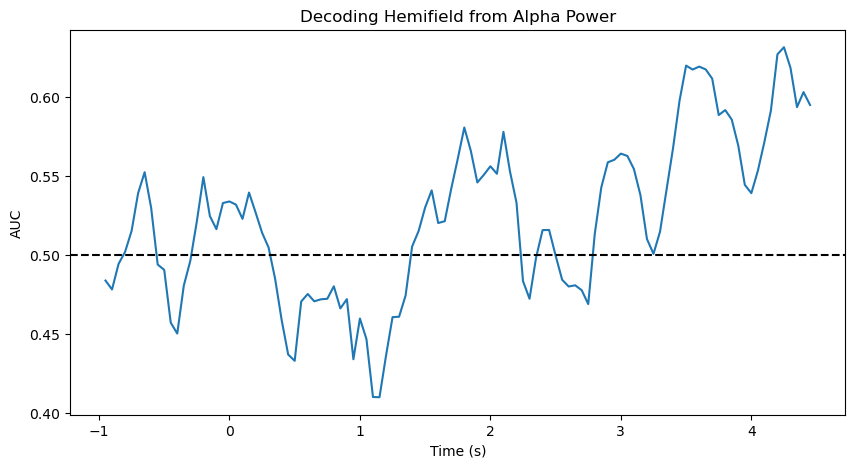

In [44]:
plt.figure(figsize=(10, 5))
plt.plot(t_array_down, scores_mean.diagonal(), label='Diagonal')
plt.axhline(0.5, color='k', linestyle='--', label='Chance')
plt.xlabel('Time (s)')
plt.ylabel('AUC')
plt.title('Decoding Hemifield from Alpha Power')
plt.show()

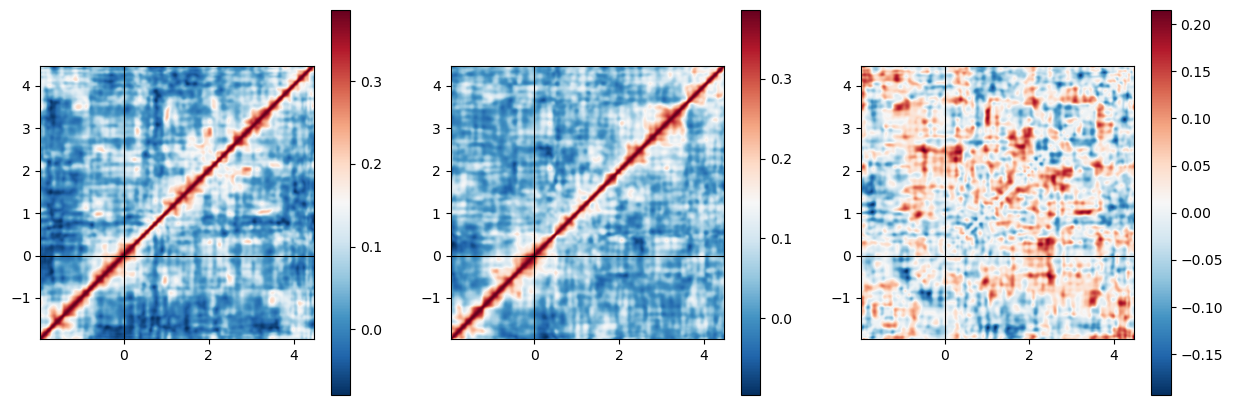

In [17]:
f, axs = plt.subplots(1, 3, figsize=(15, 5))
data_1 = X_down[y==11, :, :].mean(axis=(1))
data_2 = X_down[y==12, :, :].mean(axis=(1))
data_3 = data_1 - data_2

data_1 = StandardScaler().fit_transform(data_1)
data_2 = StandardScaler().fit_transform(data_2)
data_3 = StandardScaler().fit_transform(data_3)

RSA_1 = (data_1.T @ data_1) / data_1.shape[1]
RSA_2 = (data_2.T @ data_2) / data_2.shape[1]
# RSA_3 = (data_3.T @ data_3) / data_3.shape[1]
RSA_3 = RSA_1 - RSA_2

im1 = axs[0].imshow(RSA_1, interpolation='lanczos', origin='lower', cmap='RdBu_r', extent=[t_array_down[0], t_array_down[-1], t_array_down[0], t_array_down[-1]],
                    )
axs[0].axhline(0, color='k', lw=0.8)
axs[0].axvline(0, color='k', lw=0.8)
f.colorbar(im1, ax=axs[0])
im2 = axs[1].imshow(RSA_2, interpolation='lanczos', origin='lower', cmap='RdBu_r', extent=[t_array_down[0], t_array_down[-1], t_array_down[0], t_array_down[-1]],
                    )
axs[1].axhline(0, color='k', lw=0.8)
axs[1].axvline(0, color='k', lw=0.8)
f.colorbar(im2, ax=axs[1])
im3 = axs[2].imshow(RSA_3, interpolation='lanczos', origin='lower', cmap='RdBu_r', extent=[t_array_down[0], t_array_down[-1], t_array_down[0], t_array_down[-1]],
                    )
axs[2].axhline(0, color='k', lw=0.8)
axs[2].axvline(0, color='k', lw=0.8)
f.colorbar(im3, ax=axs[2])


plt.show()

(100, 52) (100, 52)


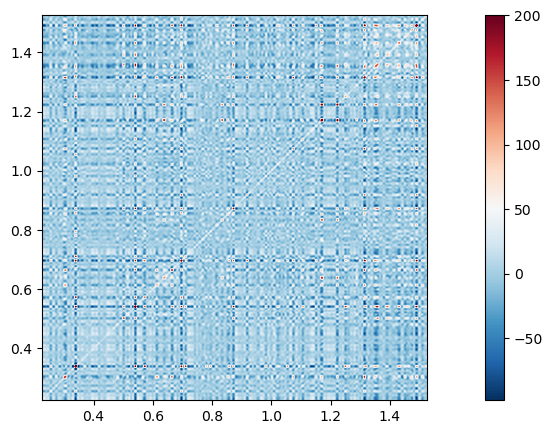

In [22]:
f, axs = plt.subplots(1, 1, figsize=(15, 5))
low_tidx = np.where(t_array_down > 0.2)[0][0]
high_tidx = np.where(t_array_down > 1.5)[0][0]
data_1 = X_down[y==11, :, low_tidx:high_tidx].mean(axis=(1))
data_2 = X_down[y==12, :, low_tidx:high_tidx].mean(axis=(1))
print(data_1.shape, data_2.shape)
data = np.concatenate([data_1, data_2], axis=0)
data = StandardScaler().fit_transform(data)
RSA_ = data @ data.T
im = axs.imshow(RSA_, # - np.eye(scores_mean.shape[0]), 
           interpolation='lanczos', 
           origin='lower', 
           cmap='RdBu_r', 
           extent=[t_array_down[low_tidx], t_array_down[high_tidx], t_array_down[low_tidx], t_array_down[high_tidx]],
          )
f.colorbar(im, ax=axs)
plt.show()
